# Train a CNN to identify layers from time domain samples

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
class CNN1D(nn.Module):
    def __init__(self, input_channels=1, num_classes=3):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = torch.mean(x, dim=2)  # Global average pooling
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_values = []
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_steps = len(train_loader)
        
        # Initialize tqdm with a progress bar for each epoch
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for i, (inputs, labels) in enumerate(pbar):
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Update tqdm with the current loss
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (i + 1))  # Update loss on progress bar
        
        # Store the loss after each epoch
        loss_values.append(running_loss / total_steps)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / total_steps:.4f}")
    
    return loss_values

In [3]:
# Load the dataset with weights_only=False
data = torch.load("Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([3, 1, 2, 1, 1, 3, 1, 3, 1, 2])


In [4]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([3, 1, 2, 1, 1, 3, 1, 3, 1, 2])
num_layers_adjusted (for training): tensor([2, 0, 1, 0, 0, 2, 0, 2, 0, 1])


In [5]:
# Adjust labels from 1–N to 0–(N-1)
num_layers_adjusted = num_layers - 1  # torch.Size([100])
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4

# Unsqueeze to add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [100, 1, 1024]

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Initialize the model, criterion, and optimizer
model = CNN1D(input_channels=1, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/10: 100%|██████████| 235/235 [00:11<00:00, 20.17batch/s, loss=1.01]


Epoch [1/10], Loss: 1.0095


Epoch 2/10: 100%|██████████| 235/235 [00:11<00:00, 21.10batch/s, loss=0.928]


Epoch [2/10], Loss: 0.9280


Epoch 3/10: 100%|██████████| 235/235 [00:11<00:00, 20.90batch/s, loss=0.873]


Epoch [3/10], Loss: 0.8726


Epoch 4/10: 100%|██████████| 235/235 [00:11<00:00, 21.21batch/s, loss=0.677]


Epoch [4/10], Loss: 0.6766


Epoch 5/10: 100%|██████████| 235/235 [00:11<00:00, 20.86batch/s, loss=0.579]


Epoch [5/10], Loss: 0.5786


Epoch 6/10: 100%|██████████| 235/235 [00:11<00:00, 20.61batch/s, loss=0.53] 


Epoch [6/10], Loss: 0.5304


Epoch 7/10: 100%|██████████| 235/235 [00:11<00:00, 20.39batch/s, loss=0.504]


Epoch [7/10], Loss: 0.5043


Epoch 8/10: 100%|██████████| 235/235 [00:11<00:00, 20.51batch/s, loss=0.476]


Epoch [8/10], Loss: 0.4761


Epoch 9/10: 100%|██████████| 235/235 [00:11<00:00, 20.89batch/s, loss=0.49] 


Epoch [9/10], Loss: 0.4899


Epoch 10/10: 100%|██████████| 235/235 [00:11<00:00, 21.03batch/s, loss=0.469]


Epoch [10/10], Loss: 0.4689


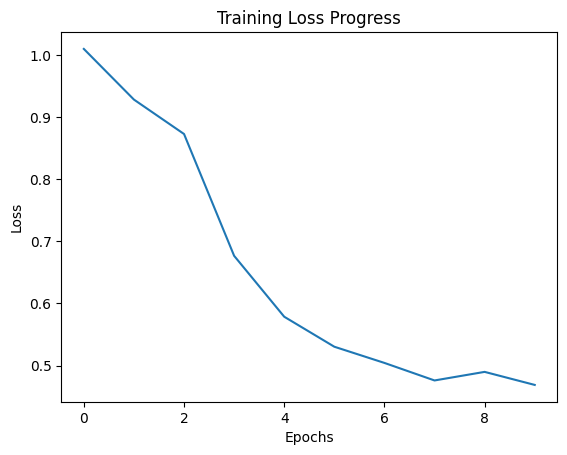

In [6]:
# Train the model
loss_values = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()


Validation Accuracy: 0.7850


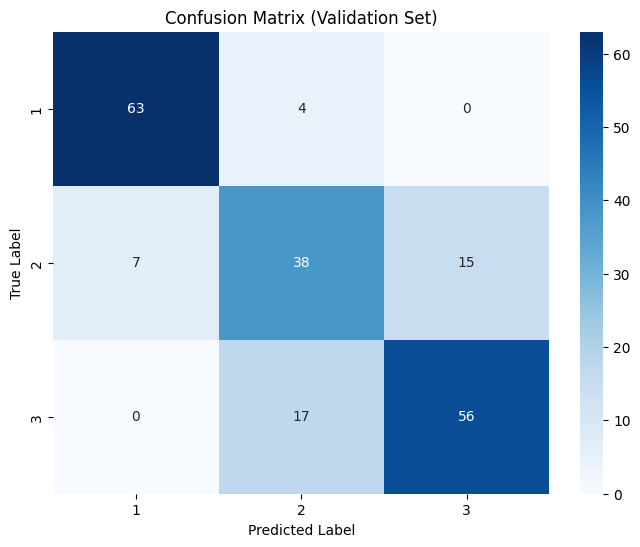

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\nValidation Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()